#### HW2 Solution - Lunar Lander using DQN

In [6]:
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import count
import torch.nn.functional as F

from matplotlib import pyplot as plt

In [7]:
# Check CUDA availability
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("CUDA is available. Using GPU...")
else:
    print("CUDA is not available. Using CPU...")

CUDA is available. Using GPU...


In [8]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Neural Network Model Definition
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

In [11]:
# Hyperparameters
learning_rate = 1e-4
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
batch_size = 64
max_memory_size = 100000
target_update = 10  # Update target network every 10 episodes
max_timesteps_per_episode = 2000  # You can adjust this limit

episode_rewards = []

In [12]:
# Environment setup
env = gym.make('LunarLander-v3')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Q-Network
policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # Set the target network to evaluation mode

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=max_memory_size)  # Experience replay memory

In [7]:

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(output_dim)]], dtype=torch.long)

# Training loop
num_episodes = 2000
for episode in range(num_episodes):
    state = env.reset()[0]
    state = torch.tensor([state], dtype=torch.float32).to(device)
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** episode))
    
    # Initialize the total reward for the episode
    total_reward = 0
    
    # Initialize timestep
    timestep = 0
    
    while True:
        timestep += 1
        action = select_action(state, epsilon)
        next_state, reward, done, _,_ = env.step(action.item())
        next_state = torch.tensor([next_state], dtype=torch.float32).to(device)
        
        total_reward += reward
        
        reward = torch.tensor([reward], dtype=torch.float32)
        
        memory.append((state, action, next_state, reward, done))
        
        if done or timestep >= max_timesteps_per_episode:
            if total_reward >= -10:
                print(f"Episode {episode}: Total Reward: {total_reward} Epsilon: {epsilon}")
            episode_rewards.append(total_reward)
            
            # Save models giving rewards over 250
            if total_reward > 250 and episode > 1950:
                # Save the model after training
                torch.save(policy_net.state_dict(), 'policy/policy_net.pth'+str(episode))
                torch.save(policy_net, 'policy/policy_net_complete.pth'+str(episode))

            break
            
        state = next_state.to(device)
        
        
        
        # Start training once the replay memory is large enough
        if len(memory) > batch_size:
            transitions = random.sample(memory, batch_size)
            batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
            
            batch_state = torch.cat(batch_state).to(device)
            batch_action = torch.cat(batch_action).to(device)
            batch_next_state = torch.cat(batch_next_state).to(device)
            batch_reward = torch.cat(batch_reward).to(device)
            batch_done = torch.tensor(batch_done, dtype=torch.uint8).to(device)
           
            # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
            current_q_values = policy_net(batch_state).gather(1, batch_action).to(device)
            
            # Compute Q(s_{t+1}) for all next states.
            next_q_values = target_net(batch_next_state).max(1)[0].detach()
            # Compute the expected Q values
            expected_q_values = batch_reward + (gamma * next_q_values * (1 - batch_done))
            
            # Compute MSE or Huber loss loss
            #loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
            loss = F.mse_loss(current_q_values, expected_q_values.unsqueeze(1))
            
            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
            
    # Update the target network
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Print episode stats
    #print(f"Episode {episode}: Total reward = {total_reward}")

print('Complete')
env.close()


C:\Users\raoji\AppData\Local\Temp\ipykernel_13732\3737123050.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float32).to(device)


Episode 51: Total Reward: -3.7799893695812017 Epsilon: 0.7744209942832987
Episode 67: Total Reward: -3.074568788573089 Epsilon: 0.7147372386831304
Episode 75: Total Reward: 12.612938144622888 Epsilon: 0.6866430931872
Episode 91: Total Reward: -8.429157169873548 Epsilon: 0.6337242817644086
Episode 99: Total Reward: 6.581483369496752 Epsilon: 0.6088145090359075
Episode 119: Total Reward: 10.930926869800942 Epsilon: 0.5507399854171278
Episode 128: Total Reward: 36.05393127799479 Epsilon: 0.5264466124450268
Episode 131: Total Reward: -9.616355639939428 Epsilon: 0.5185893309484582
Episode 144: Total Reward: -0.6919393326144387 Epsilon: 0.4858739637363177
Episode 149: Total Reward: -6.445524348970423 Epsilon: 0.4738479773082269
Episode 156: Total Reward: 33.17474766165677 Epsilon: 0.4575100055400051
Episode 160: Total Reward: 1.1667187044148335 Epsilon: 0.44842820346097695
Episode 161: Total Reward: -6.7374550934343915 Epsilon: 0.4461860624436721
Episode 162: Total Reward: 20.304951341069184

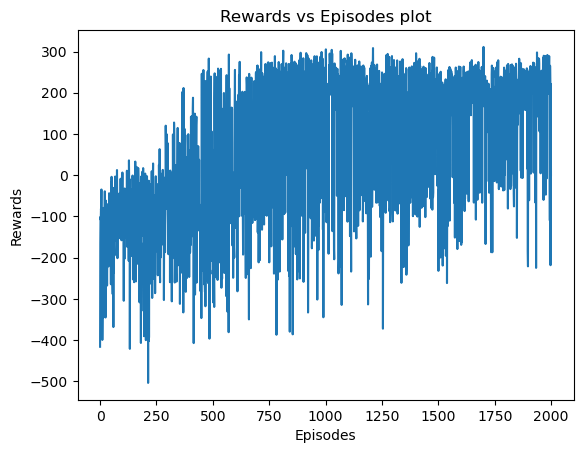

In [8]:
# plot total rewards per episode

plt.plot(episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Rewards vs Episodes plot')
plt.show()

In [ ]:
# def test_policy(env, policy_net, episodes=20):
#     for episode in range(episodes):
#         policy_net.eval()
#         state = env.reset()[0]
#         done = False
#         total_new_reward = 0
#         timestep = 0

#         while not done:
#             timestep += 1
#             state = torch.tensor([state], dtype=torch.float32)
#             with torch.no_grad():
#                 action = policy_net(state).max(1)[1].view(1, 1)
#             state, reward, done, _ ,_ = env.step(action.item())
#             total_new_reward += reward

#             if done or timestep >= 2000:
#                 print(f"Test Episode {episode}: Total Reward: {total_new_reward}")
#                 break
                
# policy_net_optimal = torch.load('policy/policy_net_complete.pth1975')

# env = gym.make("LunarLander-v3",render_mode='human')          
# test_policy(env,policy_net_optimal)
    